# Segmentation Using Snakes

**11/23/2025**

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt

# for reading in images: 
import skimage.data as data
from skimage.io import imread 

# for doing segmentation

import skimage.segmentation as seg 

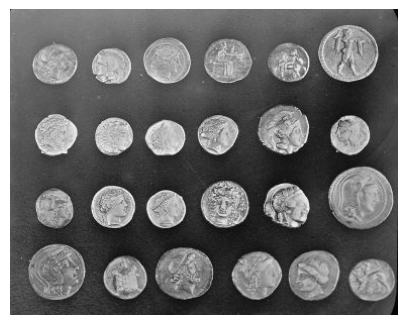

In [2]:
coinIm = data.coins()

plt.figure(figsize = (5,5))
plt.imshow(coinIm, 'gray')
plt.axis('off')
plt.show()

_Let's try using Snakes to segment on these coins._

In [3]:
# use to create contours for initial snakes
# didn't work well, so tried other things but wanted to keep this function regardless
def circle_points(resolution, center, radius):
    """Generate points defining a circle on an image."""
    radians = np.linspace(0, 2*np.pi, resolution)

    c = center[1] + radius*np.cos(radians)
    r = center[0] + radius*np.sin(radians)
    
    return np.array([c, r]).T

# Exclude last point because a closed path should not have duplicate points
points = circle_points(200, [55,45], 22)[:-1]

snake = seg.active_contour(coinIm, points)

# plt.imshow(coinIm)
# plt.plot(points[:, 0], points[:, 1], '--r', lw=3)
# plt.plot(snake[:, 0], snake[:, 1], '-b', lw=3);

_Well that looks terrible, could we try using the gradient approach from Hw 8?_

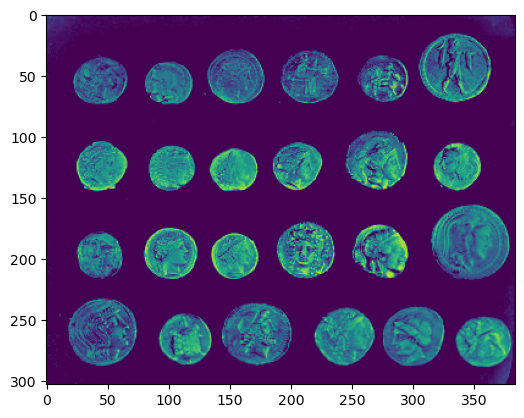

In [4]:
# cleaning up the images: 

# smooth with gaussian then take otsu: 
sigma = 35
from skimage.filters import threshold_otsu, gaussian

coinGauss = np.clip(coinIm - gaussian(coinIm, sigma = sigma, preserve_range = True), 0, None)
coinGauss *= 255 / np.max(coinGauss)
coinThresh = coinGauss > threshold_otsu(coinGauss)

plt.imshow(coinGauss)

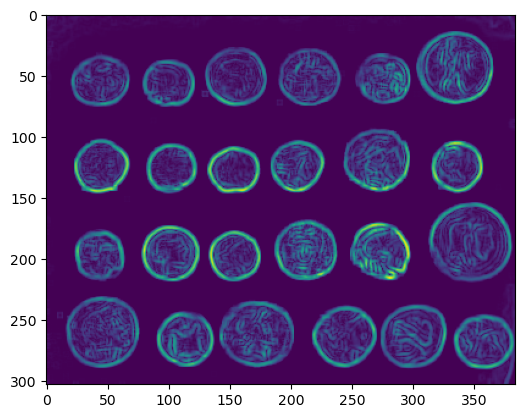

In [5]:
# setting up the gradients: 

from skimage import measure as skmeasure
from scipy import ndimage

x = np.arange(-2,3)[::-1] # reverse so negative numbers are last

sobelX, sobelY = np.meshgrid(x,x)

gradX = ndimage.convolve(input = coinGauss, weights = sobelX, mode = 'nearest')
gradY = ndimage.convolve(input = coinGauss, weights = sobelY, mode = 'nearest')

coinGrad = np.sqrt(gradX **2 + gradY ** 2)
plt.imshow(coinGrad)


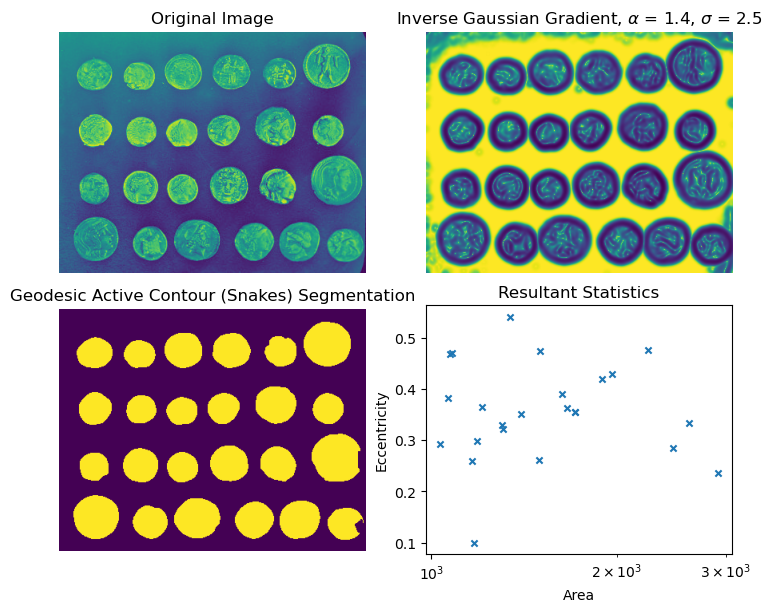

In [6]:
# following a snake tutorial: 
alpha = 1.4
sigma = 2.5
coinG = seg.inverse_gaussian_gradient(coinGauss, alpha = alpha, sigma = sigma)

init_ls = np.zeros(coinIm.shape, dtype=np.int8)
init_ls[10:-10, 10:-10] = 1
ls = seg.morphological_geodesic_active_contour(
    coinG,
    num_iter=200,
    init_level_set=init_ls,
    smoothing=1,
    balloon=-1,
    threshold=0.45,
)

fig, ([ax1,ax2], [ax3,ax4]) = plt.subplots(2,2, figsize = (7,6), layout = 'constrained')


ax1.imshow(coinIm)
ax1.set_title('Original Image')
ax2.imshow(coinG)
ax2.set_title(f'Inverse Gaussian Gradient, $\\alpha$ = {alpha}, $\sigma$ = {sigma}')
ax3.imshow(ls)
ax3.set_title('Geodesic Active Contour (Snakes) Segmentation')

ax1.set_axis_off()
ax2.set_axis_off()
ax3.set_axis_off()

# get labels for segmentation statistics 
labels = skmeasure.label(ls)
stats = skmeasure.regionprops(labels)

area = [stats[i].area for i in range(len(stats))]
ecc = [stats[i].eccentricity for i in range(len(stats))]

ax4.scatter(area, ecc, marker = 'x', s = 20)
ax4.set_xlabel('Area')
ax4.set_ylabel('Eccentricity')
ax4.set_xscale('log')
ax4.set_title('Resultant Statistics')


plt.show()

_this method works best for images with clear regions of dark and light as opposed to images with strong borders. The geodesic active contour (snake) works by finding borders between regions of light and dark pixels, so the clearer this deviation, the better the segmentation. The $\alpha$ and $\sigma$ values were determined through guess and check._


_The next step is to try this on different images in the skimage.data library to see if we can generalize this to arbitrary images and try to determine the best sigma and alpha values, and if needing more sophisticated methods, try to find the best parameters such as threshold, smoothing, etc. . . in the geodesic function as well._

_The next thing I want to do is see if I can create an aritrary function that will determine the best parameters. For this, I want to see if there is a measurement property of some sort or a parameter that we can minimize?_

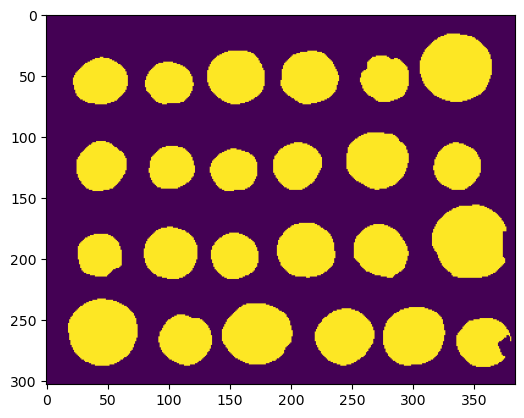

In [7]:
def snakes(im, alpha = 1.4, sigma = 2.5):
    '''run a geodesic active contour on IM.
    IM should be pre-processed and ready to be countoured.
    ALPHA: determines the steepness of the inversion for the gaussian gradient.
    SIGMA: standard deviation of gaussian kernel to use for the gradient calculations'''
    imG = seg.inverse_gaussian_gradient(im, alpha = alpha, sigma = sigma)

    init_ls = np.zeros(im.shape, dtype=np.int8)
    init_ls[10:-10, 10:-10] = 1
    ls = seg.morphological_geodesic_active_contour(
        imG,
        num_iter=200,
        init_level_set=init_ls,
        smoothing=1,
        balloon=-1,
        threshold=0.45,
    )
    return ls


plt.imshow(snakes(coinGauss))

_I've noticed that this method is really finicky when it comes to the alpha value, so finding the best alpha value will be critical for doing the best segmentation._

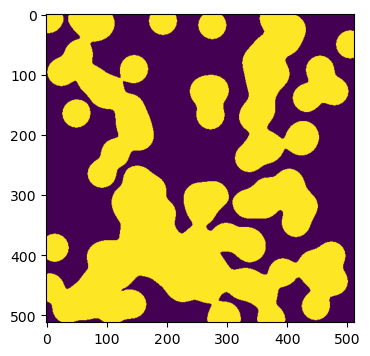

In [8]:
# let's try another image

plt.figure(figsize = (4,4))
plt.imshow(data.binary_blobs().astype(int))

_We can generate "binary blobs" and turn ths into arbitrary images, which could be a good way to create data for a machine learning approach to segmentation._

In [9]:
def generate_image(N = 512, volume_fraction = 0.5):
    labels = data.binary_blobs(length = N).astype(int)
    im = labels * 100 + 40
    im = ndimage.gaussian_filter(im, sigma = N/35)
    im = np.random.poisson(im) # scale the labels to make the noise adding better 
    im = (im* 255/np.max(im)).astype(int)
    return im, labels



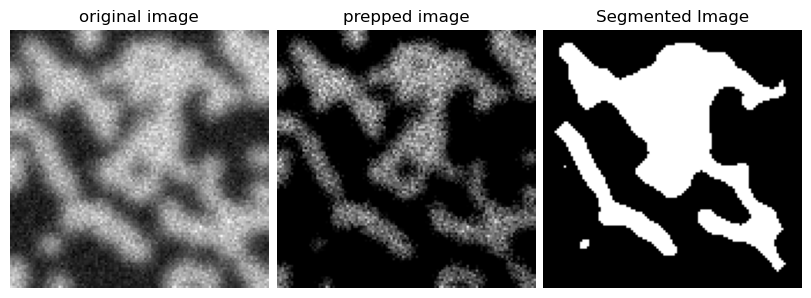

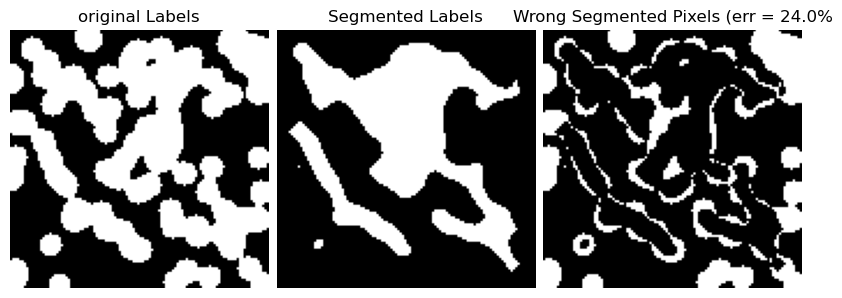

In [11]:
# trying on our blob: 
blob, blobLabels = generate_image(N = 112);
sigma = 55

blobGauss = (np.clip(blob - gaussian(blob, sigma = sigma, preserve_range = True), 0, None))
blobGauss = blobGauss * 255 / np.max(blobGauss)
snakeBlob = snakes(blobGauss, alpha = 2, sigma = 1.8)
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (8,4), layout= 'constrained')
ax1.imshow(blob, 'gray')
ax2.imshow(blobGauss, 'gray')
ax3.imshow(snakeBlob, 'gray')

ax1.set_axis_off()
ax2.set_axis_off()
ax3.set_axis_off()

ax1.set_title('original image')
ax2.set_title('prepped image')
ax3.set_title('Segmented Image')

plt.show()

# compare to the accuracy of the original binary image: 
blobErr = np.abs(blobLabels - snakeBlob) # find pixels that were characterized wrong


fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (8,4), layout= 'constrained')
ax1.imshow(blobLabels, 'gray')
ax2.imshow(snakeBlob, 'gray')
ax3.imshow(blobErr, 'gray')

ax1.set_axis_off()
ax2.set_axis_off()
ax3.set_axis_off()

ax1.set_title('original Labels')
ax2.set_title('Segmented Labels')
ax3.set_title(f'Wrong Segmented Pixels (err = {round(np.mean(blobErr) * 100, 1)}%')

plt.show()

In [ ]:
# so now we can minimize the error by fitting for sigma and alpha values 



In [12]:
# add in kmeans stuff here to test centers

from sklearn.cluster import KMeans

In [ ]:
KMeans(n_clusters = 3, random_state = 0).fit(coinIm)

In [14]:
coinIm.shape

(303, 384)

In [55]:
xSpacings = 303/4
ySpacings = 384/6
xOff = 30
yOff = 25

labelsArr = []

for i in range(1,5): 
    for j in range(1,7):
        labelsArr.append([i * xSpacings -xOff, j * ySpacings - yOff] )

labelsArr = np.array(labelsArr)

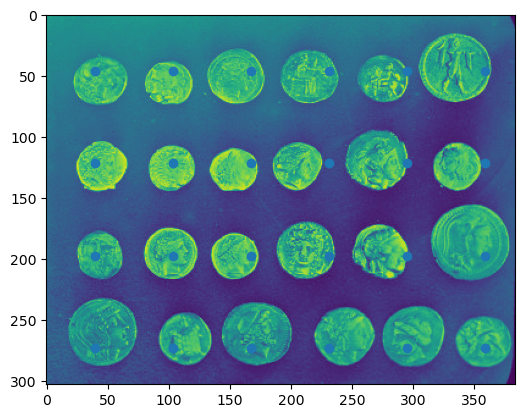

In [56]:
plt.scatter(x = labelsArr[:,1], y = labelsArr[:,0])
plt.imshow(coinIm)